In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import ipaddress
from aimlsse_api.client import GroundDataClient, SatelliteDataClient
from shapely import Polygon

In [2]:
ground_data_client = GroundDataClient(ipaddress.ip_address('127.0.0.1'), 8000)

In [15]:
area_of_interest = gpd.GeoDataFrame.from_file('input/USA.geojson')
print(area_of_interest.crs)
polygon = area_of_interest.iloc[0]['geometry']

epsg:4326


In [7]:
stations_meta = ground_data_client.queryMetadata(polygons=[
    polygon
])
print(stations_meta)

                          geometry     id  \
0       POINT (-86.78000 33.18000)    EET   
1       POINT (-86.25580 34.22910)    8A0   
2       POINT (-85.96296 32.91474)    ALX   
3       POINT (-86.39378 31.30875)    79J   
4       POINT (-85.85811 33.58817)    ANB   
...                            ...    ...   
72060  POINT (-106.33780 31.67100)  ZGBT2   
72061  POINT (-106.13330 31.40000)  TORT2   
72062   POINT (-78.69555 26.55869)   MYGF   
72063   POINT (-78.99400 26.70400)  SPGF1   
72064   POINT (-79.60000 25.75000)   KMFL   

                                        name             plot_name   network  \
0                                  ALABASTER                  None   AL_ASOS   
1                                Albertville           Albertville   AL_ASOS   
2                             ALEXANDER_CITY                  None   AL_ASOS   
3                         ANDALUSIA/OPP ARPT                  None   AL_ASOS   
4                        ANNISTON/CALHOUN CO               

In [8]:
locations = stations_meta[['id', 'geometry']]
print(locations)

          id                     geometry
0        EET   POINT (-86.78000 33.18000)
1        8A0   POINT (-86.25580 34.22910)
2        ALX   POINT (-85.96296 32.91474)
3        79J   POINT (-86.39378 31.30875)
4        ANB   POINT (-85.85811 33.58817)
...      ...                          ...
72060  ZGBT2  POINT (-106.33780 31.67100)
72061  TORT2  POINT (-106.13330 31.40000)
72062   MYGF   POINT (-78.69555 26.55869)
72063  SPGF1   POINT (-78.99400 26.70400)
72064   KMFL   POINT (-79.60000 25.75000)

[72065 rows x 2 columns]


In [9]:
satellite_data_client = SatelliteDataClient(ipaddress.ip_address('127.0.0.1'), 8010)

In [10]:
grid_cells = satellite_data_client.queryContainingGeometry(locations)
print(grid_cells)

                                                geometry cell_name  \
0      GEOMETRYCOLLECTION Z (POLYGON Z ((-124.13853 3...     10SDG   
1      GEOMETRYCOLLECTION Z (POLYGON Z ((-124.13853 3...     10SDG   
2      GEOMETRYCOLLECTION Z (POLYGON Z ((-123.00023 3...     10SEG   
3      GEOMETRYCOLLECTION Z (POLYGON Z ((-124.15275 3...     10SDH   
4      GEOMETRYCOLLECTION Z (POLYGON Z ((-123.00023 3...     10SEH   
...                                                  ...       ...   
89647  GEOMETRYCOLLECTION Z (POLYGON Z ((-67.70747 46...     19TFL   
89648  GEOMETRYCOLLECTION Z (POLYGON Z ((-67.70747 46...     19TFL   
89649  GEOMETRYCOLLECTION Z (POLYGON Z ((-67.70747 46...     19TFL   
89650  GEOMETRYCOLLECTION Z (POLYGON Z ((-67.70747 46...     19TFL   
89651  GEOMETRYCOLLECTION Z (POLYGON Z ((-67.70747 46...     19TFL   

                                             Description  index_right      id  
0      TILE PROPERTIES<br><table border=0 cellpadding...         7368   FNDC1  

In [11]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [12]:
output_dir = 'results/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [13]:
markersize = 0.1

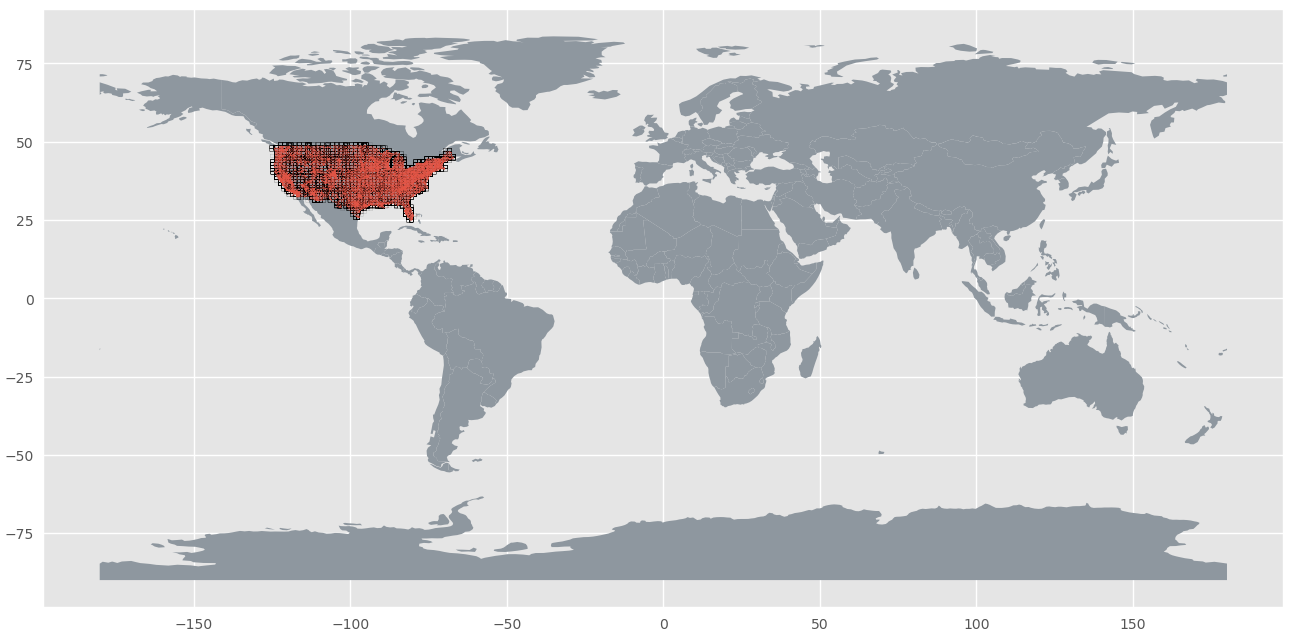

In [14]:
with plt.style.context(("seaborn", "ggplot")):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(figsize=(16,9), color='#8e979f', zorder=1);
    grid_cells.buffer(0).boundary.plot(ax=ax, edgecolor='black', alpha=0.6, linewidth=0.1, zorder=2)
    ax.scatter(stations_meta.longitude, stations_meta.latitude, s=1.0*markersize, linewidth=0.05*markersize, color='#E74C3C', edgecolor='white', zorder=3)
    plt.savefig(f'{output_dir}locations_and_grid_cells_view.svg', bbox_inches='tight', dpi=150, format='svg')